# King County Project

## Business Problem

A client in King County, WA wants to advise homeowners on **home improvement projects** that will **add to the sale value of their homes**.

**This advice should be based on data from the most recent full calendar year, 2019**.

### Sample Questions:
Enclosing a porch will increase the sale price of a home.

Converting a garage to a bedroom is a good way to increase the sale price of a home.

Upgrading to a forced-air heating system will increase the sale price of a home.

### Core Goals:
Create model

Interpret results

Make recomendations

# Initial EDA Work

### Importing Libraries and Adjusting Settings

In [1]:
# import modules for eda and plotting
import pandas as pd
import numpy as np
import scipy.stats as stats

import sqlite3

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import functions as fn

# setting plots to inline
%matplotlib inline

# setting the max number of rows displayed
pd.options.display.max_rows = 200

## SQL Dataframe

### SQL Prelim Work

#### Created Database
Earlier, wrote up a [DB Creator](DB_Creator.ipynb) notebook and ran it to create an SQL database from the raw `.csv` files.

#### Creating DataFrame From the Database

Connecting to the database, and creating a cursor object. Joining the database tables into a second main data frame. Lastly, checking basic information about the data frame.

In [2]:
# creating database, connection, and cursor
conn = sqlite3.connect('KingDB.db')  
cur = conn.cursor()

In [3]:
# checking the table names
q = """SELECT name FROM sqlite_master 
WHERE type IN ('table','view') 
AND name NOT LIKE 'sqlite_%'
ORDER BY 1"""
fn.fetch(cur, q)

[('LOOK',), ('PARC',), ('RESB',), ('SALES',)]

### Joining Tables to Create the Main Data Frame

In [4]:
# joining tables to create dataframe and appending column names
q = """SELECT*FROM SALES AS SA
       JOIN PARC AS PA
       ON SA.Major = PA.Major
       AND SA.Minor = PA.Minor
       JOIN RESB AS RE
       ON PA.Major = RE.Major
       AND PA.Minor = RE.Minor
       """
df = pd.DataFrame(fn.fetch(cur, q))
df.columns = [i[0] for i in cur.description]

In [5]:
# checking info, shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251300 entries, 0 to 251299
Columns: 156 entries, ExciseTaxNbr to AddnlCost
dtypes: object(156)
memory usage: 299.1+ MB


In [6]:
df.shape

(251300, 156)

### Creating the Lookup Data Frame

In [7]:
# joining tables to create dataframe and appending column names
q = """SELECT*FROM LOOK"""
look = pd.DataFrame(fn.fetch(cur, q))
look.columns = [i[0] for i in cur.description]

#### Checking the Lookup Data Frame

Getting basic info, checking the first row, description strings, and cleaning the columns.

In [8]:
# getting info for lookup data frame
look.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   LUType         1208 non-null   object
 1   LUItem         1208 non-null   object
 2   LUDescription  1208 non-null   object
dtypes: object(3)
memory usage: 28.4+ KB


In [9]:
# checking first row
look.head(1)

,LUType,LUItem,LUDescription
0,1,1,LAND ONLY ...


In [10]:
# checking strings
look.LUType.values[:2], look.LUItem.values[:2], look.LUDescription.values[:2]

(array(['1  ', '1  '], dtype=object),
 array(['1  ', '10 '], dtype=object),
 array(['LAND ONLY                                         ',
        'Land with new building                            '], dtype=object))

Cleaning strings and checking results.

In [11]:
# cleaning strings
look['LUType'] = fn.col_stripper(look, 'LUType')
look['LUItem'] = fn.col_stripper(look, 'LUItem')
look['LUDescription'] = fn.col_stripper(look, 'LUDescription')

In [12]:
# checking results
print(look.LUType.values)
print(look.LUItem.values)
look.LUDescription.values

['1' '1' '1' ... '99' '99' '99']
['1' '10' '11' ... '3' '4' '5']


array(['LAND ONLY', 'Land with new building',
       'Household, single family units', ..., 'AVERAGE', 'ABOVE AVERAGE',
       'EXCELLENT'], dtype=object)

### Checking & Dealing with Columns in Main Data Frame
Working through the columns of the main data frame to narrow down the list of features to a more manageable size.

In [13]:
# checking columns
list(df.columns)

['ExciseTaxNbr',
 'Major',
 'Minor',
 'DocumentDate',
 'SalePrice',
 'RecordingNbr',
 'Volume',
 'Page',
 'PlatNbr',
 'PlatType',
 'PlatLot',
 'PlatBlock',
 'SellerName',
 'BuyerName',
 'PropertyType',
 'PrincipalUse',
 'SaleInstrument',
 'AFForestLand',
 'AFCurrentUseLand',
 'AFNonProfitUse',
 'AFHistoricProperty',
 'SaleReason',
 'PropertyClass',
 'SaleWarning',
 'Unnamed: 0',
 'Major',
 'Minor',
 'PropName',
 'PlatName',
 'PlatLot',
 'PlatBlock',
 'Range',
 'Township',
 'Section',
 'QuarterSection',
 'PropType',
 'Area',
 'SubArea',
 'SpecArea',
 'SpecSubArea',
 'DistrictName',
 'LevyCode',
 'CurrentZoning',
 'HBUAsIfVacant',
 'HBUAsImproved',
 'PresentUse',
 'SqFtLot',
 'WaterSystem',
 'SewerSystem',
 'Access',
 'Topography',
 'StreetSurface',
 'RestrictiveSzShape',
 'InadequateParking',
 'PcntUnusable',
 'Unbuildable',
 'MtRainier',
 'Olympics',
 'Cascades',
 'Territorial',
 'SeattleSkyline',
 'PugetSound',
 'LakeWashington',
 'LakeSammamish',
 'SmallLakeRiverCreek',
 'OtherView',

#### Removing `Unnamed: 0` Column

In [14]:
# using custom dropper function to remove unnamed column found above
fn.dropper(df, ['Unnamed: 0'], True)

## Checking `PropertyType`, `PropertyClass`, `PropType`


In [15]:
df[['PropertyType', 'PropertyClass', 'PropType']].head(3)

,PropertyType,PropertyClass,PropType
0,3,8,R
1,2,8,R
2,3,8,R


Checking Lookup Codes

In [16]:
fn.lookup(look, 1), fn.lookup(look,4)

(   LUType LUItem                                      LUDescription
 0       1      1                                          LAND ONLY
 1       1     10                             Land with new building
 2       1     11                     Household, single family units
 3       1     12  Multiple family residence (Residential, 2-4 un...
 4       1     13  Multiple family residence (Residential, 5+ units)
 5       1     14                           Residential condominiums
 6       1     15                        Mobile home parks or courts
 7       1     16                                      Hotels/motels
 8       1     17                              Institutional lodging
 9       1     18          All other residential not elsewhere coded
 10      1     19                                 Vacation and cabin
 11      1      2                             LAND WITH NEW BUILDING
 12      1     21                          Food and kindred products
 13      1     22                 

#### Making `PropType` Lookup Data Frame

In [17]:
# PropType Codes 
codes = ['C', 'K', 'M', 'N', 'R', 'T', 'U', 'X']
ptypes = ['Commercial', 'Condominium', 'Coal & Mineral Rights',\
            'Mining', 'Residential', 'Timber', 'Undivided Interest', 'Exempt']
pt = {'LUItem': codes, 'LUDescription': ptypes}
PropTypes = pd.DataFrame().from_dict(pt)
PropTypes

,LUItem,LUDescription
0,C,Commercial
1,K,Condominium
2,M,Coal & Mineral Rights
3,N,Mining
4,R,Residential
5,T,Timber
6,U,Undivided Interest
7,X,Exempt


### Light Data Cleaning

Changing datestrings to datetime objects,  and sale price strings to floats in the main pandas dataframe. Adding a 'DocumentYear' column to main the data frame.

In [18]:
# changing date strings to datetime objects
df.DocumentDate = pd.to_datetime(df.DocumentDate)

# adding a document year column
df['DocumentYear'] = df['DocumentDate'].apply(lambda x: x.year)

# converting SalePrice string to float
df['SalePrice'] = df['SalePrice'].astype('float')

### Checking For Null Values

In [19]:
# checking nulls and shape
print(df.isna().sum())
df.shape

ExciseTaxNbr                   0
Major                          0
Minor                          0
DocumentDate                   0
SalePrice                      0
RecordingNbr                   0
Volume                         0
Page                           0
PlatNbr                        0
PlatType                       0
PlatLot                        0
PlatBlock                      0
SellerName                     0
BuyerName                      0
PropertyType                   0
PrincipalUse                   0
SaleInstrument                 0
AFForestLand                   0
AFCurrentUseLand               0
AFNonProfitUse                 0
AFHistoricProperty             0
SaleReason                     0
PropertyClass                  0
SaleWarning                    0
Major                          0
Minor                          0
PropName                   11473
PlatName                   29223
PlatLot                        0
PlatBlock                      0
Range     

(251300, 156)

Checking `'SpecArea'` and `'SpecSubArea'` columns.

In [20]:
# inspecting columns with custom chunker() function
fn.chunker(df, ['SpecArea', 'SpecSubArea'])

,SpecArea,SpecSubArea
0,None,None
1,None,None
2,None,None


It looks like the `'SpecArea'` and `'SpecSubArea'` are extraneous columns for modeling purposes so they will be dropped.

In [21]:
# dropping columns and checking first row
fn.dropper(df, ['SpecArea', 'SpecSubArea'], True)
df.head(1)

,ExciseTaxNbr,Major,Minor,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear
0,2743355,638580,0110,2015-07-14,190000.0,20150715002686,,,,,...,0,1,1963,0,0,0,0,3,0,2015


### Inspecting Columns with Null Values

In [22]:
# checking problematic columns
li = ['PropName', 'PlatName', 'DirectionPrefix', 'DirectionSuffix', 'ZipCode']
fn.chunker(df, li)

,PropName,PlatName,DirectionPrefix,DirectionSuffix,ZipCode
0,,OLYMPIC TERRACE ADD,,S,98188
1,None,VINTNER'S PLACE,NE,,None
2,,LAKE UNION ADD,,N,98103


#### Keeping ```'ZipCode'``` Column but Dropping Others

The othe columns have to do with Plat Mapping and seem irrelevant to the model. Zip Codes can have value as proxy indicators so may be useful later. Keeping for now.

In [23]:
# dropping extraneous columns
fn.dropper(df, li[:4], True)

### Checking for Duplicate Columns

Before going any further, finding and dropping any dupes.

In [24]:
# checking for duplicate columns
df.loc[:, df.columns.duplicated()].head(3)

,Major,Minor,PlatLot,PlatBlock,Major,Minor
0,638580,0110,11,,638580,0110
1,894677,0240,24,,894677,0240
2,408330,4150,9,42,408330,4150


In [25]:
# dropping duplicate column and checking shape
df = df.loc[:,~df.columns.duplicated()]
df.shape

(251300, 144)

###  Swapping Column Order & Adding an `'ID'` Feature
Doing a little house cleaning by moving the `'SalePrice'` target variable to the front of the data frame and creating an `'ID'` feature by combining the `'Major'` and `'Minor'` values into a single string. Moving the `'ID'` feature to second position in the data frame.

In [26]:
# moving target variable to the front column of the df
columns = list(df.columns)
columns = [columns[4]] + columns[:4] + columns[5:]
df = df[columns]
df.head(3)

,SalePrice,ExciseTaxNbr,Major,Minor,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,...,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear
0,190000.0,2743355,638580,0110,2015-07-14,20150715002686,,,,,...,0,1,1963,0,0,0,0,3,0,2015
1,818161.0,2841697,894677,0240,2016-12-21,20161228000896,,,,,...,0,0,2016,0,0,0,0,3,0,2016
2,0.0,2860712,408330,4150,2017-03-15,20170426000922,,,,,...,0,0,1906,0,0,0,0,4,0,2017


#### Creating `ID` Feature and Moving it to Front of Data Frame

In [27]:
# creating 'ID' column
df['ID'] = df['Major'] + df['Minor']

In [28]:
# getting info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251300 entries, 0 to 251299
Columns: 145 entries, SalePrice to ID
dtypes: datetime64[ns](1), float64(1), int64(1), object(142)
memory usage: 278.0+ MB


In [29]:
# moving ID column to the front column of the df
columns = list(df.columns)
columns = columns[:1] + [columns[144]] + columns[1:144]
df = df[columns]
df.head(1)

,SalePrice,ID,ExciseTaxNbr,Major,Minor,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,...,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear
0,190000.0,6385800110,2743355,638580,0110,2015-07-14,20150715002686,,,,...,0,1,1963,0,0,0,0,3,0,2015


In [30]:
fn.dropper(df, ['Major', 'Minor'], True)

## Checking For Duplicate Rows
Looking for duped rows before cleaning columns.

In [31]:
# checking for duplicate rows
df[df.duplicated()]

,SalePrice,ID,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear


## Data Understanding
Getting a feel for what is going on in data.

### Checking For Duplicate `ID`s

In [32]:
# checking for duplicated ids
dupe_ids = df[df.duplicated(subset=['ID'], keep=False)]
print(dupe_ids.shape)
dupe_ids.head(3)

(123215, 143)


,SalePrice,ID,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear
0,190000.0,6385800110,2743355,2015-07-14,20150715002686,,,,,,...,0,1,1963,0,0,0,0,3,0,2015
1,818161.0,8946770240,2841697,2016-12-21,20161228000896,,,,,,...,0,0,2016,0,0,0,0,3,0,2016
3,0.0,5101404256,2813396,2016-07-25,20160802000964,,,,,,...,0,0,1949,0,0,0,0,3,0,2016


#### Filtering Zero Prices

In [33]:
# getting non-zero rows
nz_dupes = dupe_ids[dupe_ids['SalePrice'] != 0].sort_values(by='ID')
print(nz_dupes.shape)
nz_dupes.head()

(76248, 143)


,SalePrice,ID,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear
144761,394950.0,0001000040,2804519,2016-06-17,20160623001164,,,,,,...,0,0,2016,0,0,0,0,3,0,2016
198044,126000.0,0001000040,2760609,2015-10-06,20151009000683,,,,,,...,0,0,2016,0,0,0,0,3,0,2015
198045,126000.0,0001000042,2760609,2015-10-06,20151009000683,,,,,,...,0,0,2016,0,0,0,0,3,0,2015
192863,485500.0,0001000042,3018323,2019-10-29,20191031001228,,,,,,...,0,0,2016,0,0,0,0,3,0,2019
60412,380000.0,0001000042,2809927,2016-07-07,20160718001671,,,,,,...,0,0,2016,0,0,0,0,3,0,2016


#### Focusing in on Some Features to Get Context

In [34]:
# getting context
nz_dupes[['SalePrice', 'ID', 'ExciseTaxNbr',\
          'RecordingNbr','DocumentDate',\
          'Address', 'PropertyType']].head(5)

,SalePrice,ID,ExciseTaxNbr,RecordingNbr,DocumentDate,Address,PropertyType
144761,394950.0,0001000040,2804519,20160623001164,2016-06-17,1502 M ST NE,3
198044,126000.0,0001000040,2760609,20151009000683,2015-10-06,1502 M ST NE,1
198045,126000.0,0001000042,2760609,20151009000683,2015-10-06,1424 M ST NE,1
192863,485500.0,0001000042,3018323,20191031001228,2019-10-29,1424 M ST NE,11
60412,380000.0,0001000042,2809927,20160718001671,2016-07-07,1424 M ST NE,3


#### Using Lookup Codes on `PropertyType`

In [35]:
fn.lookup(look,1)

,LUType,LUItem,LUDescription
0,1,1,LAND ONLY
1,1,10,Land with new building
2,1,11,"Household, single family units"
3,1,12,"Multiple family residence (Residential, 2-4 un..."
4,1,13,"Multiple family residence (Residential, 5+ units)"
5,1,14,Residential condominiums
6,1,15,Mobile home parks or courts
7,1,16,Hotels/motels
8,1,17,Institutional lodging
9,1,18,All other residential not elsewhere coded


#### Checking `ExciseTaxNbr`

In [36]:
ext_nb = df[df.duplicated(subset=['ExciseTaxNbr'], keep=False)]
ext_nb[ext_nb['SalePrice'] != 0].head()

,SalePrice,ID,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear
132,1512000.0,9822700460,2888358,2017-09-08,,,,,,,...,0,0,2019,0,0,0,0,3,0,2017
133,1512000.0,9822700465,2888358,2017-09-08,,,,,,,...,0,0,2019,0,0,0,0,3,0,2017
173,875000.0,1522059185,2809560,2016-07-13,20160715001611,,,,,,...,0,0,2017,0,0,0,0,3,0,2016
174,875000.0,1522059183,2809560,2016-07-13,20160715001611,,,,,,...,0,0,2016,0,0,0,0,3,0,2016
175,875000.0,1522059187,2809560,2016-07-13,20160715001611,,,,,,...,0,0,2017,0,0,0,0,3,0,2016


### An Example `ID`
Focusing on a single `ID` for a closer look at how the data works. 

In [37]:
example = nz_dupes[['SalePrice', 'ID', 'ExciseTaxNbr',\
          'RecordingNbr','DocumentDate',\
          'Address', 'PropertyType']]
example[example.ID == '0001000042'].sort_values(by='DocumentDate')

,SalePrice,ID,ExciseTaxNbr,RecordingNbr,DocumentDate,Address,PropertyType
198045,126000.0,0001000042,2760609,20151009000683,2015-10-06,1424 M ST NE,1
60412,380000.0,0001000042,2809927,20160718001671,2016-07-07,1424 M ST NE,3
192863,485500.0,0001000042,3018323,20191031001228,2019-10-29,1424 M ST NE,11


### Preliminary Understanding

It seems that the `ID` (`Major` + `Minor`) feature is tied to the property address, and `ExciseTaxNumber` is tied to the transaction date. In the example dataframe above, we can see the history of a single parcel of land. In 2015, the undeveloped land (`PropertyType 1`) was sold. 2016 saw it sold again, with some type type of building attached (`PropertyType 3`). Finally, the sale in 2019 was recorded with a `PropertyType` of 11, indicating that a home was built on the land. It looks like **`PropertyType` 11, 12, and 13** will be the focus primary of the model data frame.

## Diving Deeper into the Data
Looking at a property with multiple building with multiple buildings.

In [38]:
deep = df[df.ID == '0822119001']
deep = deep[deep['DocumentYear'] == 2019]
deep = deep[['SalePrice', 'ID', 'ExciseTaxNbr',\
          'RecordingNbr','DocumentDate',\
          'Address', 'BldgNbr', 'PropertyType']]
deep.shape

(63, 8)

In [39]:
deep.head(2)

,SalePrice,ID,ExciseTaxNbr,RecordingNbr,DocumentDate,Address,BldgNbr,PropertyType
135744,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,1,0
135745,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,10,0


#### Looks like there is some corrupt `PropertyType` data with an invalid code of '0'.
Checking all 63 rows.

In [40]:
deep

,SalePrice,ID,ExciseTaxNbr,RecordingNbr,DocumentDate,Address,BldgNbr,PropertyType
135744,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,1,0
135745,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,10,0
135746,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,11,0
135747,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,12,0
135748,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,13,0
135749,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,14,0
135750,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,15,0
135751,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,16,0
135752,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,17,0
135753,70000.0,0822119001,3017542,20191028001102,2019-10-21,20904 677TH PL SE 98045,18,0


#### Checking Number of Buildings

In [41]:
len(deep.BldgNbr.unique())

21

Looks like there are 42 invalid entries Dropping.

#### Dropping '0' Values

In [42]:
drop_idx = deep[deep.PropertyType == '0'].index
deep.drop(drop_idx, inplace=True)

In [43]:
print(deep.shape)
deep.head(2)

(21, 8)


,SalePrice,ID,ExciseTaxNbr,RecordingNbr,DocumentDate,Address,BldgNbr,PropertyType
137341,70000.0,0822119001,3017076,,2019-10-21,20904 677TH PL SE 98045,1,3
137342,70000.0,0822119001,3017076,,2019-10-21,20904 677TH PL SE 98045,10,3


#### Looking Good
The shape of the data frame make more sense after dropping rows.

## Deeper Understanding
Feeling confident that `'0'` `SalePrice` & `PropertyType` rows can be safely removed for cleaning purposes. 

## Dropping Zeroes

In [44]:
drop_idx = df[df.SalePrice == 0].index
df.drop(drop_idx, inplace=True)

In [45]:
df.shape

(173636, 143)

In [46]:
drop_idx = df[df.PropertyType == '0'].index
df.drop(drop_idx, inplace=True)

In [47]:
df.shape

(172808, 143)

## 2019 Data

Since we want to train our model on 2019 data, we are going to isolate the 2019 information into a new data frame and use it to define our target and predictors.

#### Creating Initial 2019 DataFrame

Creating data frame and checking basic information

In [48]:
# isolating 2019 data
df = df[df['DocumentYear']==2019]

In [49]:
# checking data frame shape and looking for NaNs
print(df.shape)
df.isna().sum()

(29766, 143)


SalePrice                    0
ID                           0
ExciseTaxNbr                 0
DocumentDate                 0
RecordingNbr                 0
Volume                       0
Page                         0
PlatNbr                      0
PlatType                     0
PlatLot                      0
PlatBlock                    0
SellerName                   0
BuyerName                    0
PropertyType                 0
PrincipalUse                 0
SaleInstrument               0
AFForestLand                 0
AFCurrentUseLand             0
AFNonProfitUse               0
AFHistoricProperty           0
SaleReason                   0
PropertyClass                0
SaleWarning                  0
Range                        0
Township                     0
Section                      0
QuarterSection               0
PropType                     0
Area                         0
SubArea                      0
DistrictName                 0
LevyCode                     0
CurrentZ

In [50]:
# checking first few rows
df.head(3)

,SalePrice,ID,ExciseTaxNbr,DocumentDate,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,...,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear
5,560000.0,2130430120,3027422,2019-12-20,20191226000848,,,,,,...,0,0,1989,0,0,0,0,3,0,2019
6,435000.0,9406520630,3002257,2019-07-22,20190730001339,,,,,,...,0,0,1994,0,0,0,0,3,2500,2019
12,450000.0,1402810020,2993601,2019-06-04,20190614000489,,,,,,...,0,0,1986,0,0,0,0,3,0,2019


# Inspecting Columns and Dropping Extraneous Features
Working through the list of columns step by step and removing features that seem like they will have minimal impact of the model.

In [51]:
# printing list of columns and copying it to external text file for ease of use
list(df.columns)

['SalePrice',
 'ID',
 'ExciseTaxNbr',
 'DocumentDate',
 'RecordingNbr',
 'Volume',
 'Page',
 'PlatNbr',
 'PlatType',
 'PlatLot',
 'PlatBlock',
 'SellerName',
 'BuyerName',
 'PropertyType',
 'PrincipalUse',
 'SaleInstrument',
 'AFForestLand',
 'AFCurrentUseLand',
 'AFNonProfitUse',
 'AFHistoricProperty',
 'SaleReason',
 'PropertyClass',
 'SaleWarning',
 'Range',
 'Township',
 'Section',
 'QuarterSection',
 'PropType',
 'Area',
 'SubArea',
 'DistrictName',
 'LevyCode',
 'CurrentZoning',
 'HBUAsIfVacant',
 'HBUAsImproved',
 'PresentUse',
 'SqFtLot',
 'WaterSystem',
 'SewerSystem',
 'Access',
 'Topography',
 'StreetSurface',
 'RestrictiveSzShape',
 'InadequateParking',
 'PcntUnusable',
 'Unbuildable',
 'MtRainier',
 'Olympics',
 'Cascades',
 'Territorial',
 'SeattleSkyline',
 'PugetSound',
 'LakeWashington',
 'LakeSammamish',
 'SmallLakeRiverCreek',
 'OtherView',
 'WfntLocation',
 'WfntFootage',
 'WfntBank',
 'WfntPoorQuality',
 'WfntRestrictedAccess',
 'WfntAccessRights',
 'WfntProximityI

## `SALES` Table Columns
Inspecting and dropping columns from the `SALES` table.

#### Checking First Batch of Columns

Seem to be a mix of blank columns and administrative information that will probably have no effect on the model.

In [52]:
# checking columns 
li = ['RecordingNbr', 'Volume', 'Page', 'PlatNbr' ,'PlatType',\
    'PlatLot', 'PlatBlock', 'SellerName', 'BuyerName']
fn.chunker(df,li)

,RecordingNbr,Volume,Page,PlatNbr,PlatType,PlatLot,PlatBlock,SellerName,BuyerName
5,20191226000848,,,,,,,DOYLE REGAN M+STERLING C ...,SHAW HEATHER C ...
6,20190730001339,,,,,,,CRAMER NEIL C+PAM R+ET AL ...,HANSON BRYAN L+KAILI ...
12,20190614000489,,,,,,,BRASHER DAVID+MONIQUE A ...,SEITZ ANDREW+MODELSKI EVE ...


Dropping columns and checking the results.

In [53]:
# dropping blank and extraneous columns
fn.dropper(df, li, True)

In [54]:
# checking first row
df.head(1)

,SalePrice,ID,ExciseTaxNbr,DocumentDate,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,...,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost,DocumentYear
5,560000.0,2130430120,3027422,2019-12-20,11,6,3,N,N,N,...,0,0,1989,0,0,0,0,3,0,2019


In [55]:
# creating data frame to inspect latest batch of columns
li =['SaleInstrument',
 'AFForestLand',
 'AFCurrentUseLand',
 'AFNonProfitUse',
 'AFHistoricProperty',
 'SaleReason',
 'PropertyClass',
 'SaleWarning']
fn.chunker(df, li)

,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning
5,3,N,N,N,N,1,8,
6,3,N,N,N,N,1,8,
12,3,N,N,N,N,1,8,


#### Using Lookup Table For More Info on the Features
Checking lookup data and dropping columns. Looking up info on the `SaleInstrument` and `PropertyClass` features.

In [56]:
# using custom lookup function to print info 
fn.lookup(look, 6), fn.lookup(look, 4)

(     LUType LUItem                    LUDescription
 1002      6      1                             None
 1003      6     10             Real Estate Contract
 1004      6     11           Purchaser's Assignment
 1005      6     13              Seller's Assignment
 1006      6     15                  Quit Claim Deed
 1007      6     18                   Trustees' Deed
 1008      6     19                  Executor's Deed
 1009      6      2                    Warranty Deed
 1010      6     20                   Fiduciary Deed
 1011      6     21                   Sheriff's Deed
 1012      6     22           Bargain and Sales Deed
 1013      6     23                   Receivers Deed
 1014      6     24             Deed of Personal Rep
 1015      6     25         Judgment Per Stipulation
 1016      6     26            Other - See Affidavit
 1017      6     27                             DEED
 1018      6     28  Forfeiture Real Estate Contract
 1019      6      3          Statutory Warrant

#### Dropping Columns
Seems to be more administrative data that can be safely dropped.

In [57]:
# dropping extraneous columns
fn.dropper(df, li, True)

## `PARC` Table Columns
Inspecting and dropping columns from the `PARC` table.

#### Inspecting Next Batch and Checking `'DistrictName'` Feature

In [58]:
# checking columns
li = ['Range',
 'Township',
 'Section',
 'QuarterSection',
 'PropType',
 'Area',
 'SubArea',
 'DistrictName',
 'LevyCode',
 'CurrentZoning']
fn.chunker(df, li)

,Range,Township,Section,QuarterSection,PropType,Area,SubArea,DistrictName,LevyCode,CurrentZoning
5,6,26,13,SE,R,70,2,DUVALL,1155,R4.5
6,6,22,27,SW,R,56,3,MAPLE VALLEY,1813,R-6
12,6,26,13,SE,R,70,2,DUVALL,1155,R4.5


In [59]:
# getting unique values
df['DistrictName'].unique()

array(['DUVALL', 'MAPLE VALLEY', 'KIRKLAND', 'KING COUNTY', 'SEATTLE',
       'REDMOND', 'SAMMAMISH', 'BELLEVUE', 'AUBURN', 'BLACK DIAMOND',
       'KENT', 'LAKE FOREST PARK', 'SHORELINE', 'ISSAQUAH', 'WOODINVILLE',
       'FEDERAL WAY', 'MERCER ISLAND', 'RENTON', 'SNOQUALMIE',
       'NORTH BEND', 'KENMORE', 'DES MOINES', 'ENUMCLAW', 'COVINGTON',
       'CARNATION', 'SeaTac', 'NEWCASTLE', 'BURIEN', 'BOTHELL', 'TUKWILA',
       'CLYDE HILL', 'SKYKOMISH', 'ALGONA', 'NORMANDY PARK',
       'HUNTS POINT', 'MEDINA', 'MILTON', 'PACIFIC', 'YARROW POINT',
       'BEAUX ARTS'], dtype=object)

#### Slicing List and Dropping Features Except for `'PropType'` & `'DistrictName'`
District name seems like it may be useful so will be kept for now.

In [60]:
li = li[:4] + li[5:7] + li[8:10]
fn.dropper(df, li, True)

#### Processing Next Batch
Creating dataframe and using lookup data to inspect features.

In [61]:
li = ['HBUAsIfVacant',
 'HBUAsImproved',
 'PresentUse',
 'SqFtLot',
 'WaterSystem',
 'SewerSystem',
 'Access',
 'Topography',
 'StreetSurface',
 'RestrictiveSzShape',
 'InadequateParking',
 'PcntUnusable',
 'Unbuildable',]
fn.chunker(df, li)

,HBUAsIfVacant,HBUAsImproved,PresentUse,SqFtLot,WaterSystem,SewerSystem,Access,Topography,StreetSurface,RestrictiveSzShape,InadequateParking,PcntUnusable,Unbuildable
5,1,1,2,10523,2,2,4,0,1,0,0,0,False
6,1,1,2,7392,2,2,4,0,1,0,0,0,False
12,1,1,2,9940,2,2,4,0,1,0,2,0,False


In [62]:
# looking up HBU As If Vacant, HBU As Improved, Present Use features
fn.lookup(look,103), fn.lookup(look, 104), fn.lookup(look, 102)

(    LUType LUItem            LUDescription
 213    103      1            SINGLE FAMILY
 214    103     10  AMUSEMENT/ENTERTAINMENT
 215    103     11                 CULTURAL
 216    103     12      EDUCATIONAL SERVICE
 217    103     13       COMMERCIAL SERVICE
 218    103     14         RETAIL/WHOLESALE
 219    103     15            MANUFACTURING
 220    103     16             AGRICULTURAL
 221    103     17                 FORESTRY
 222    103     18     FISH & WILDLIFE MGMT
 223    103     19                  MINERAL
 224    103      2                   DUPLEX
 225    103     20        REGIONAL LAND USE
 226    103     21                MIXED USE
 227    103      3                  TRIPLEX
 228    103      4              MOBILE HOME
 229    103      5        OTHER SF DWELLING
 230    103      6    MULTI-FAMILY DWELLING
 231    103      7          GROUP RESIDENCE
 232    103      8        TEMPORARY LODGING
 233    103      9          PARK/RECREATION,
     LUType LUItem LUDescriptio

#### Dropping First Three Columns in Batch 

In [63]:
# dropping columns
li = ['HBUAsIfVacant',
 'HBUAsImproved',
 'PresentUse']
fn.dropper(df, li, True)

#### Saving These Features for Now
'WaterSystem', 'SewerSystem', 'Access', 'Topography', 'StreetSurface', 'RestrictiveSzShape', 'InadequateParking'

In [64]:
# looking up info for Water System, Sewer System, Access features
fn.lookup(look, 56), fn.lookup(look, 57), fn.lookup(look, 55)

(    LUType LUItem       LUDescription
 989     56      1             PRIVATE
 990     56      2      WATER DISTRICT
 991     56      3  PRIVATE RESTRICTED
 992     56      4   PUBLIC RESTRICTED,
     LUType LUItem       LUDescription
 993     57      1             PRIVATE
 994     57      2              PUBLIC
 995     57      3  PRIVATE RESTRICTED
 996     57      4   PUBLIC RESTRICTED,
     LUType LUItem      LUDescription
 984     55      1         RESTRICTED
 985     55      2  LEGAL/UNDEVELOPED
 986     55      3            PRIVATE
 987     55      4             PUBLIC
 988     55      5            WALK IN)

In [65]:
#  lookup for Topography, Street Surface features
fn.lookup(look, 59), fn.lookup(look, 60)

(     LUType LUItem LUDescription
 1001     59      1           YES,
      LUType LUItem LUDescription
 1026     60      1         PAVED
 1027     60      2        GRAVEL
 1028     60      3          DIRT
 1029     60      4   UNDEVELOPED)

In [66]:
#  lookup for Restrictive Size/Shape, Inadequate Parking features
fn.lookup(look, 90), fn.lookup(look, 92)

(     LUType LUItem LUDescription
 1178     90      1           YES,
      LUType LUItem LUDescription
 1180     92      1    INADEQUATE
 1181     92      2      ADEQUATE)

#### Dropping Last two columns in Batch

In [67]:
li = ['PcntUnusable', 'Unbuildable',]
fn.dropper(df, li, True)

### Inspecting Next Batch
Features indicate if various views are available from property. Veiws do affect property values, so keeping the features for now.

In [68]:
# checking view features
li = ['MtRainier',
 'Olympics',
 'Cascades',
 'Territorial',
 'SeattleSkyline',
 'PugetSound',
 'LakeWashington',
 'LakeSammamish',
 'SmallLakeRiverCreek',
 'OtherView',]
fn.chunker(df, li)

,MtRainier,Olympics,Cascades,Territorial,SeattleSkyline,PugetSound,LakeWashington,LakeSammamish,SmallLakeRiverCreek,OtherView
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0


In [69]:
# looking up info
fn.lookup(look, 58)

,LUType,LUItem,LUDescription
997,58,1,FAIR
998,58,2,AVERAGE
999,58,3,GOOD
1000,58,4,EXCELLENT


#### Processing Next Batch
Features have to do with waterfront property issues. Will inspecting lookup data to help make drop decision later.

In [70]:
# checking waterfront features
li = ['WfntLocation',
 'WfntFootage',
 'WfntBank',
 'WfntPoorQuality',
 'WfntRestrictedAccess',
 'WfntAccessRights',
 'WfntProximityInfluence',
 'TidelandShoreland']
fn.chunker(df, li)

,WfntLocation,WfntFootage,WfntBank,WfntPoorQuality,WfntRestrictedAccess,WfntAccessRights,WfntProximityInfluence,TidelandShoreland
5,0,0,0,0,0,N,N,0
6,0,0,0,0,0,N,N,0
12,0,0,0,0,0,N,N,0


In [71]:
# printing lookup info
print('location', fn.lookup(look, 50)) 
print('bank' ,fn.lookup(look, 52)) 
print('poor quality', fn.lookup(look, 51))
print('rest. access', fn.lookup(look, 53))
print('tideland', fn.lookup(look, 54))

location     LUType LUItem LUDescription
964     50      1      DUWAMISH
965     50      2   ELLIOTT BAY
966     50      3   PUGET SOUND
967     50      4    LAKE UNION
968     50      5    SHIP CANAL
969     50      6     LAKE WASH
970     50      7     LAKE SAMM
971     50      8    OTHER LAKE
972     50      9  RIVER/SLOUGH
bank     LUType LUItem LUDescription
974     52      1           LOW
975     52      2        MEDIUM
976     52      3          HIGH
977     52      4       NO BANK
poor quality     LUType LUItem LUDescription
973     51      1           YES
rest. access     LUType LUItem         LUDescription
978     53      1          To Residence
979     53      2         To Waterfront
980     53      3  No Waterfront Access
tideland     LUType LUItem                      LUDescription
981     54      1                       UPLANDS ONLY
982     54      2  UPLANDS WITH TIDELANDS/SHORELANDS
983     54      3          TIDELANDS/SHORELANDS ONLY


#### Checking Nuisance Features
Seem like important factors in housing prices, so keeping for now.

In [72]:
li = ['LotDepthFactor',
 'TrafficNoise',
 'AirportNoise',
 'PowerLines',
 'OtherNuisances',
 'NbrBldgSites',
 'Contamination',
 'DNRLease',
 'AdjacentGolfFairway',
 'AdjacentGreenbelt']
fn.chunker(df, li)

,LotDepthFactor,TrafficNoise,AirportNoise,PowerLines,OtherNuisances,NbrBldgSites,Contamination,DNRLease,AdjacentGolfFairway,AdjacentGreenbelt
5,0,0,0,N,N,0,0,N,N,N
6,0,0,0,N,N,0,0,N,N,N
12,0,0,0,N,N,0,0,N,N,N


In [73]:
# lookup info for traffic noise and contamination
fn.lookup(look,95), fn.lookup(look,93)

(     LUType LUItem LUDescription
 1183     95      1      MODERATE
 1184     95      2          HIGH
 1185     95      3       EXTREME,
      LUType LUItem LUDescription
 1182     93      1           YES)

### More Administrative Features
Inspecting and dropping extraneous features.

In [74]:
li = ['HistoricSite',
 'CurrentUseDesignation',
 'NativeGrowthProtEsmt',
 'Easements',
 'OtherDesignation',
 'DeedRestrictions',
 'DevelopmentRightsPurch']
fn.chunker(df,li)

,HistoricSite,CurrentUseDesignation,NativeGrowthProtEsmt,Easements,OtherDesignation,DeedRestrictions,DevelopmentRightsPurch
5,0,0,N,N,N,N,N
6,0,0,N,N,N,N,N
12,0,0,N,N,N,N,N


In [75]:
# checking 'AdjacentGreenbelt', 'HistoricSite', 'CurrentUseDesignation' info
fn.lookup(look,105), fn.lookup(look,67), fn.lookup(look,16)

(    LUType LUItem   LUDescription
 238    105      3  Separate Value,
      LUType LUItem     LUDescription
 1052     67      1          DISTRICT
 1053     67      2         INVENTORY
 1054     67      3        DESIGNATED
 1055     67      4  VACANT HIST LAND,
     LUType LUItem        LUDescription
 770     16      1                AGRIC
 771     16      2       TIMBER (84.34)
 772     16      3           OPEN SPACE
 773     16      4  FOREST LAND (84.33)
 774     16      5                CLFRS)

In [76]:
# dropping features
fn.dropper(df, li, True)

### Hazard Features
Seem important, so probably keeping for now.

In [77]:
li = ['CoalMineHazard',
 'CriticalDrainage',
 'ErosionHazard',
 'LandfillBuffer',
 'HundredYrFloodPlain',
 'SeismicHazard',
 'LandslideHazard',
 'SteepSlopeHazard',]
fn.chunker(df, li)

,CoalMineHazard,CriticalDrainage,ErosionHazard,LandfillBuffer,HundredYrFloodPlain,SeismicHazard,LandslideHazard,SteepSlopeHazard
5,N,N,N,N,N,N,N,N
6,N,N,N,N,N,N,N,N
12,N,N,N,N,N,N,N,N


### Miscellaneous Features
Checking last few features from the `PARC` table.

In [78]:
li = ['Stream',
 'Wetland',
 'SpeciesOfConcern',
 'SensitiveAreaTract',
 'WaterProblems',
 'TranspConcurrency',
 'OtherProblems',]
fn.chunker(df,li)

,Stream,Wetland,SpeciesOfConcern,SensitiveAreaTract,WaterProblems,TranspConcurrency,OtherProblems
5,N,N,N,N,N,N,N
6,N,N,N,N,N,N,N
12,N,N,N,N,N,N,N


## `RESB` Table Columns
Inspecting and dropping columns from the `RESB` table.

## Isolating Target and Initial Predictors

Since two of the questions we want to answer relate to the HeatSystem and SqFtEnclosedPorch features, we are going to isolate them, and our SalePrice target variable, into seperate dataframes. 

### HeatSystem Dataframe

Isolating ```'SalePrice'``` target and ```'HeatSystem'``` predictor in Checking first the few rows, shape, nulls, and unique values.

In [79]:
# Isolating SalePrice target and HeatSystem predictor into a data frame. 
heat_df = df[['SalePrice','HeatSystem']].copy()
heat_df.head(3)

,SalePrice,HeatSystem
5,560000.0,5
6,435000.0,5
12,450000.0,1


In [80]:
# checking shape
heat_df.shape

(29766, 2)

In [81]:
# checking NaNs
heat_df.isna().sum()

SalePrice     0
HeatSystem    0
dtype: int64

#### Prepping for Model Data Frame

Creating a dictionary of the lookup code descriptions, and using it to make a list of values for use in a new column.  Will use this column in a one-hot-encoding procedure for more descriptive column names in the model dataframe.

In [82]:
# checking unique values
print(heat_df.HeatSystem.unique())
len(heat_df.HeatSystem.unique())

['5' '1' '4' '7' '6' '3' '0' '2' '8']


9

#### Grabbing Lookup Codes

In [83]:
# looking up HeatSystem codes 
lu_df = fn.lookup(look, 108)
lu_df

,LUType,LUItem,LUDescription
243,108,1,Floor-Wall
244,108,2,Gravity
245,108,3,Radiant
246,108,4,Elec BB
247,108,5,Forced Air
248,108,6,Hot Water
249,108,7,Heat Pump
250,108,8,Other


#### Making & Mapping Dictionary of Lookup Codes & Descriptions
Zipping lists of keys and values for dictionary from lookup data frame columns. Creating dictionary and mapping it to the `heat_df` data frame.

In [84]:
# creating heatnames dictionary
heatnames = dict(zip(lu_df.LUItem,lu_df.LUDescription))

In [85]:
heat_df.HeatSystem.map(heatnames)

5         Forced Air
6         Forced Air
12        Floor-Wall
21        Forced Air
22        Forced Air
             ...    
251275    Forced Air
251276    Forced Air
251278     Heat Pump
251279           NaN
251291     Heat Pump
Name: HeatSystem, Length: 29766, dtype: object

#### Making `HeatNames` Column & Dropping `HeatSystems` From Data Frame

In [86]:
heat_df['HeatNames'] = heat_df.HeatSystem.map(heatnames)

In [87]:
fn.dropper(heat_df, 'HeatSystem', True)

#### Checking for `NaN` values and replacing with `'NA'` strings.
Checking for `NaN` types. Since `NaN` values mean there was no lookup code available, replacing `NaN` values with `'NA'` strings.

In [88]:
# checking for NaNs
heat_df['HeatNames'].isna().sum()

80

In [89]:
# filling NaNs with strings
heat_df.fillna('NA', inplace=True)

In [90]:
# checking work
heat_df.isna().sum()

SalePrice    0
HeatNames    0
dtype: int64

#### One-Hot Encoding the HeatSystem Predictor

Instantiating the encoder, fitting the encoder to `heat_df[['HeatNames']]` , and transforming the data. Creating a new `heat_ohe` data frame, dropping the `'HeatNames'` column from ` heat_df2`, and concatenating it will `heat_ohe` to form a new `model_df` data frame.

In [91]:
# instantiating, fitting and transforming
ohcoder = OneHotEncoder(drop='first')

ohcoder.fit(heat_df[['HeatNames']])

transformed = ohcoder.transform(heat_df[['HeatNames']])

In [92]:
# creating heat_ohe data frame and checking the first few columns
heat_ohe = pd.DataFrame(transformed.todense(),\
                       columns = ohcoder.get_feature_names())
heat_ohe.head(3)

,x0_Floor-Wall,x0_Forced Air,x0_Gravity,x0_Heat Pump,x0_Hot Water,x0_NA,x0_Other,x0_Radiant
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
# dropping the 'HeatNames' column from heat_df
heat_dropped = heat_df.drop('HeatNames', axis=1)

#### Creating `model_df` Data Frame

In [94]:
# creating the model dataframe and checking first few rows
model_df = pd.concat([heat_dropped, heat_ohe], axis=1)
model_df.head(3)

,SalePrice,x0_Floor-Wall,x0_Forced Air,x0_Gravity,x0_Heat Pump,x0_Hot Water,x0_NA,x0_Other,x0_Radiant
0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### `model_df` Correlation Matrix and Heatmap

In [95]:
model_df.corr()

,SalePrice,x0_Floor-Wall,x0_Forced Air,x0_Gravity,x0_Heat Pump,x0_Hot Water,x0_NA,x0_Other,x0_Radiant
SalePrice,1.000000,-0.008967,0.011643,-0.005456,-0.005781,-0.006176,0.002655,-0.005976,0.002610
x0_Floor-Wall,-0.008967,1.000000,-0.327213,-0.007944,-0.062377,-0.029423,-0.009674,-0.004584,-0.021444
x0_Forced Air,0.011643,-0.327213,1.000000,-0.074856,-0.587738,-0.277237,-0.091152,-0.043192,-0.202054
x0_Gravity,-0.005456,-0.007944,-0.074856,1.000000,-0.014270,-0.006731,-0.002213,-0.001049,-0.004906
x0_Heat Pump,-0.005781,-0.062377,-0.587738,-0.014270,1.000000,-0.052850,-0.017376,-0.008234,-0.038518
x0_Hot Water,-0.006176,-0.029423,-0.277237,-0.006731,-0.052850,1.000000,-0.008196,-0.003884,-0.018169
x0_NA,0.002655,-0.009674,-0.091152,-0.002213,-0.017376,-0.008196,1.000000,-0.001277,-0.005974
x0_Other,-0.005976,-0.004584,-0.043192,-0.001049,-0.008234,-0.003884,-0.001277,1.000000,-0.002831
x0_Radiant,0.002610,-0.021444,-0.202054,-0.004906,-0.038518,-0.018169,-0.005974,-0.002831,1.000000


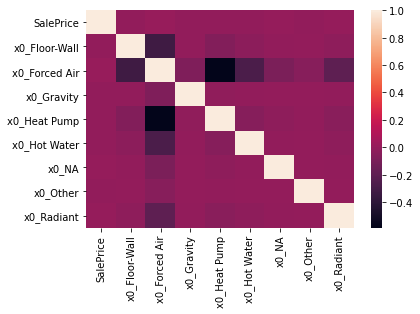

In [96]:
sns.heatmap(model_df.corr());

#### EnclosedPoarch Dataframe

In [97]:
# isolating SalePrice target and SqFtEnclosedPorch predictor
porch_df = df[['SqFtEnclosedPorch']]
porch_df.head()

,SqFtEnclosedPorch
5,0
6,0
12,0
21,0
22,0
